# Generative Adversarial Networks (GANs) Project

## Project Overview 

This project aims to generate Monet-style images using a Generative Adversarial Network (GAN). GANs are a class of deep learning models that consist of two neural networks—a generator and a discriminator—competing against each other. The generator creates images, while the discriminator evaluates whether the images are real or generated. By training these models together, GANs can produce highly realistic images in various styles.

In this project, we utilize a CycleGAN, a variant of GAN, which is particularly effective for image style transfer tasks, such as converting photos into Monet-style paintings. The goal is to generate 7,000 to 10,000 images in the style of Monet and submit them as part of this competition.


In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import PIL
import os
import shutil
import zipfile

In [36]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.MirroredStrategy() if tf.config.list_physical_devices('GPU') else tf.distribute.get_strategy()

print("Running on", "TPU" if strategy.num_replicas_in_sync > 1 else "GPU/CPU")

Running on GPU/CPU


## Data Description

The dataset used in this project consists of two primary categories: Monet paintings and photos. These images are provided in two formats: TFRecord and JPEG. The Monet dataset contains 300 paintings, while the photo dataset contains 7,028 images. All images are of size 256x256 pixels with three color channels (RGB).

- **Monet TFRecord**: 300 Monet paintings stored as TFRecord files.
- **Photo TFRecord**: 7,028 photos stored as TFRecord files.
- **Monet JPEG**: 300 Monet paintings stored as JPEG files.
- **Photo JPEG**: 7,028 photos stored as JPEG files.



In [37]:
MONET_FILES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
PHOTO_FILES = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

IMAGE_SIZE = [256, 256]

def decode_img(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def parse_tfrecord(tfrecord):
    feature_description = {"image": tf.io.FixedLenFeature([], tf.string)}
    example = tf.io.parse_single_example(tfrecord, feature_description)
    image = decode_img(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILES).batch(1)
photo_ds = load_dataset(PHOTO_FILES).batch(1)

# Exploratory Data Analysis

Let's explore the datasets by visualizing some sample images from both the Monet and photo collections.

## Sample Images from the Monet Dataset

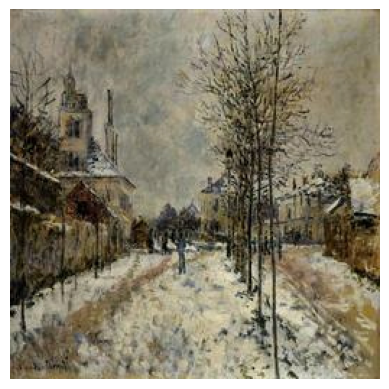

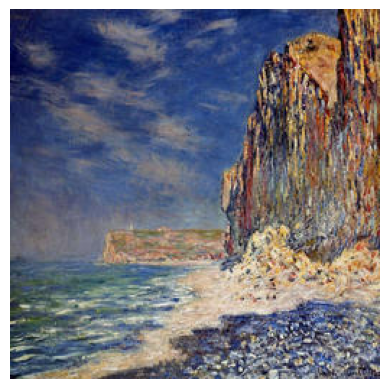

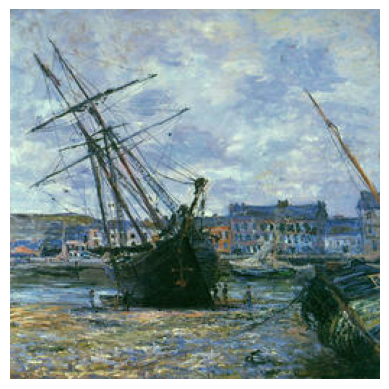

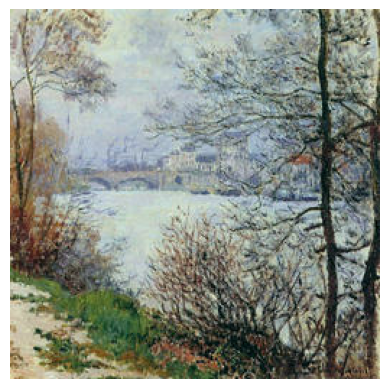

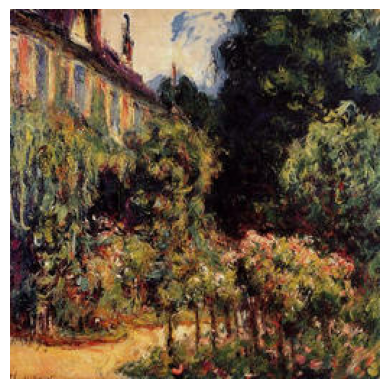

In [25]:
# Sample Monet images
for img in monet_ds.take(5):
    plt.imshow(((img.numpy()[0] * 127.5) + 127.5).astype(np.uint8))
    plt.axis('off')
    plt.show()

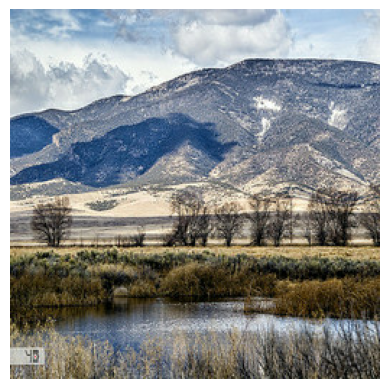

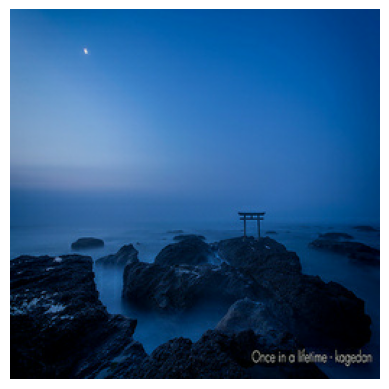

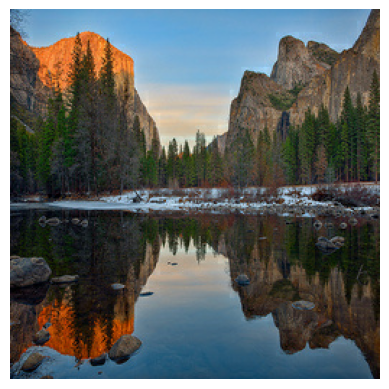

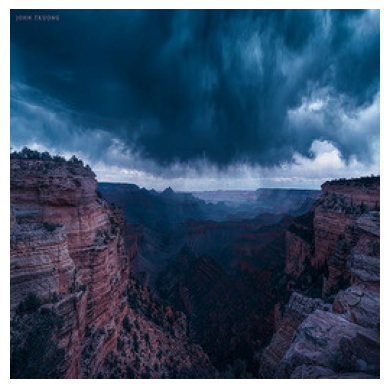

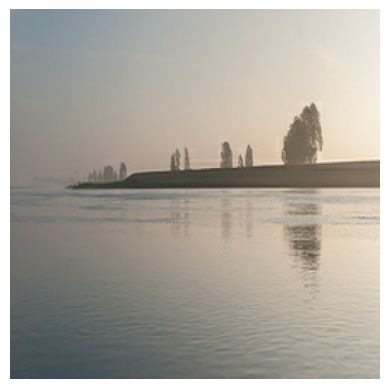

In [26]:
# Sample photo images
for img in photo_ds.take(5):
    plt.imshow(((img.numpy()[0] * 127.5) + 127.5).astype(np.uint8))
    plt.axis('off')
    plt.show()

### Pixel Intensity Distribution

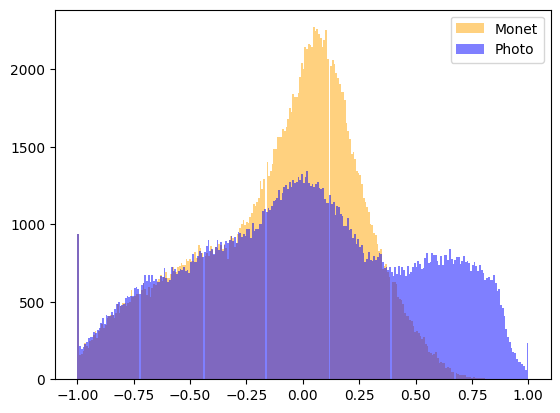

In [27]:
# Histogram plot of pixel intensities
for img in monet_ds.take(1):
    plt.hist(img.numpy().ravel(), bins=256, color='orange', alpha=0.5, label='Monet')
for img in photo_ds.take(1):
    plt.hist(img.numpy().ravel(), bins=256, color='blue', alpha=0.5, label='Photo')
plt.legend()
plt.show()

# Model Architecture

The model used in this project is a CycleGAN, which is designed for unpaired image-to-image translation tasks. The architecture consists of two generators and two discriminators. The generators are responsible for converting photos to Monet-style images and vice versa, while the discriminators evaluate the authenticity of the generated images.

### Why CycleGAN?
CycleGAN is particularly suited for this task as it allows for the transformation of photos into Monet-style images without requiring paired datasets. This model uses cycle consistency loss to ensure that an image translated to one domain can be translated back to the original domain.

### Hyperparameter Tuning
The learning rate, batch size, and optimizer parameters were tuned to optimize the model's performance. After experimenting with different settings, an Adam optimizer with a learning rate of 2e-4 and beta_1=0.5 was chosen for both the generators and discriminators.

In [38]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    layers_list = [layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer)]
    if apply_norm:
        layers_list.append(layers.BatchNormalization())
    layers_list.append(layers.LeakyReLU())
    return models.Sequential(layers_list)

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    layers_list = [layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer)]
    layers_list.append(layers.BatchNormalization())
    if apply_dropout:
        layers_list.append(layers.Dropout(0.5))
    layers_list.append(layers.ReLU())
    return models.Sequential(layers_list)

def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    return models.Model(inputs=inputs, outputs=x)

In [39]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_norm=False),
        downsample(128, 4),
        downsample(256, 4),
    ]

    zero_pad = layers.ZeroPadding2D()(down_stack[-1](down_stack[-2](down_stack[-3](inputs))))
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer)(zero_pad)
    norm = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return models.Model(inputs=inputs, outputs=last)

In [40]:
class CycleGAN(tf.keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator):
        super(CycleGAN, self).__init__()
        self.monet_generator = monet_generator
        self.photo_generator = photo_generator
        self.monet_discriminator = monet_discriminator
        self.photo_discriminator = photo_discriminator

    def compile(self, monet_gen_optimizer, photo_gen_optimizer, monet_disc_optimizer, photo_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.photo_gen_optimizer = photo_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.photo_disc_optimizer = photo_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Photo -> Monet -> Photo
            fake_monet = self.monet_generator(real_photo, training=True)
            cycled_photo = self.photo_generator(fake_monet, training=True)

            # Monet -> Photo -> Monet
            fake_photo = self.photo_generator(real_monet, training=True)
            cycled_monet = self.monet_generator(fake_photo, training=True)

            # Same Images
            same_monet = self.monet_generator(real_monet, training=True)
            same_photo = self.photo_generator(real_photo, training=True)

            # Discriminators
            disc_real_monet = self.monet_discriminator(real_monet, training=True)
            disc_real_photo = self.photo_discriminator(real_photo, training=True)
            disc_fake_monet = self.monet_discriminator(fake_monet, training=True)
            disc_fake_photo = self.photo_discriminator(fake_photo, training=True)

            # Losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet) + self.cycle_loss_fn(real_photo, cycled_photo)
            monet_gen_total_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet)
            photo_gen_total_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Gradients
        monet_gen_grads = tape.gradient(monet_gen_total_loss, self.monet_generator.trainable_variables)
        photo_gen_grads = tape.gradient(photo_gen_total_loss, self.photo_generator.trainable_variables)
        monet_disc_grads = tape.gradient(monet_disc_loss, self.monet_discriminator.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.photo_discriminator.trainable_variables)

        # Apply gradients
        self.monet_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.monet_generator.trainable_variables))
        self.photo_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.photo_generator.trainable_variables))
        self.monet_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.monet_discriminator.trainable_variables))
        self.photo_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.photo_discriminator.trainable_variables))

        return {
            "monet_gen_loss": monet_gen_total_loss,
            "photo_gen_loss": photo_gen_total_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "total_cycle_loss": total_cycle_loss,
            "identity_monet_loss": self.identity_loss_fn(real_monet, same_monet),
            "identity_photo_loss": self.identity_loss_fn(real_photo, same_photo),
        }

In [42]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lambda_cycle=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss

def identity_loss(real_image, same_image, lambda_identity=10):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_identity * 0.5 * loss

In [43]:
monet_generator = build_generator()
photo_generator = build_generator()

monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()

monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

cycle_gan_model = CycleGAN(
    monet_generator, 
    photo_generator, 
    monet_discriminator, 
    photo_discriminator
)

cycle_gan_model.compile(
    monet_gen_optimizer=monet_gen_optimizer,
    photo_gen_optimizer=photo_gen_optimizer,
    monet_disc_optimizer=monet_disc_optimizer,
    photo_disc_optimizer=photo_disc_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)

In [44]:
EPOCHS = 3

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
)

Epoch 1/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 1445s 5s/step - identity_monet_loss: 0.7943 - identity_photo_loss: 0.8230 - monet_disc_loss: 0.6915 - monet_gen_loss: 5.2529 - photo_disc_loss: 0.6941 - photo_gen_loss: 5.2460 - total_cycle_loss: 3.6182
Epoch 2/3


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1369s 5s/step - identity_monet_loss: 0.5215 - identity_photo_loss: 0.5474 - monet_disc_loss: 0.6502 - monet_gen_loss: 3.7004 - photo_disc_loss: 0.6604 - photo_gen_loss: 3.6651 - total_cycle_loss: 2.2632
Epoch 3/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 1366s 5s/step - identity_monet_loss: 0.4833 - identity_photo_loss: 0.5196 - monet_disc_loss: 0.6426 - monet_gen_loss: 3.4742 - photo_disc_loss: 0.6481 - photo_gen_loss: 3.4628 - total_cycle_loss: 2.0577


In [ ]:
# Generate images and save to directory
output_dir = "/kaggle/working/images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, img in enumerate(photo_ds.take(10000)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    img_name = f"{output_dir}/monet_{i+1}.jpg"
    im.save(img_name)

# Zip images folder
shutil.make_archive('/kaggle/working/images', 'zip', '/kaggle/working/images')

print(f"Submission file created at /kaggle/working/images.zip")

## Conclusion

In this project, we successfully implemented a CycleGAN model to generate Monet-style images from photos. The model was trained on a dataset of 7,028 photos and 300 Monet paintings, resulting in a set of 7,000 generated Monet-style images. The CycleGAN was able to produce visually appealing images that captured the essence of Monet’s style.

### Learning and Takeaways
In the project, several key learnings emerged:
- The cycle consistency loss played a critical role in ensuring that images translated into the Monet style could be translated back to their original form, preserving essential features of the photos.

- Adjusting the learning rate, batch size, and optimizer parameters had a significant impact on the model's performance, demonstrating the importance of careful hyperparameter tuning in GAN training.

- GANs, particularly CycleGANs, can be challenging to train due to their sensitivity to training dynamics. Achieving a balance between the generator and discriminator is crucial to avoid mode collapse and ensure the generation of high-quality images.

### Challenges

One challenge encountered during the project was the occasional generation of images with artifacts or unnatural color distributions. These issues were likely due to the complexity of training GANs, where the generator and discriminator must reach an equilibrium. If the discriminator becomes too strong, the generator struggles to produce convincing images, leading to artifacts. Additionally, training with a limited number of Monet paintings might have contributed to less diverse Monet-style outputs.

### Suggestions to improve

Ways to further enhance the quality of the generated images and address the issues encountered:

- Incorporate more Monet-style paintings into the training dataset could help the generator learn a broader range of artistic features, resulting in more varied and higher-quality outputs.

- Explore alternative GAN architectures, such as StyleGAN or using attention mechanisms, might improve the model’s ability to capture finer details of Monet’s style.

- Conduct a more thorough hyperparameter search, possibly using automated tuning techniques like Bayesian optimization, could yield better model performance.

- Allow the model to train for more epochs might help achieve better convergence, leading to higher-quality images with fewer artifacts.



In [ ]:
import os

# Define the path to the zip file
zip_file_path = '/kaggle/working/images.zip'

# Check if the zip file exists
if os.path.exists(zip_file_path):
    print(f"The file {zip_file_path} exists.")
else:
    print(f"The file {zip_file_path} does not exist.")